In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import torch
import tensorflow as tf
import os
import sklearn
import pandas as pd
import numpy as np
import torch.nn as nn
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras import layers

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [9]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [10]:
# SOURCE for preprocessing functions: 
# Abstract Segmentation NLP notebook (https://www.kaggle.com/anshulmehtakaggl/abstract-segmentation-nlp)

# Creating a function to read the txt Files
# This function returns all the lines in the txt file as a list
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

# Creating a function to read the txt Files
# This function returns all the lines in the txt file as a list
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

#Preprocessing Functions
# Returns a list of dictionaries of abstract's lines
# Dict Format --> {'TARGET':'Background/Results/Objetive/Concludion','Text':'The actual statement'}
def preprocess_data(filename):
    input_lines=get_lines(filename)
    #This will be used to separte the abstracts from  one another using String mets
    abstract_lines=""
    # Empty list of abstracts        
    abstract_samples=[]
    for line in input_lines:
        # Check for a new abstract
        if line.startswith("###"):
            abstract_id=line
            # And since we are in a new abstract we will Reset the abstract_lines
            abstract_lines=""
        # Check for a new line \n escape seq
        elif line.isspace():
            # Split the Lines of the abstract and will return a list of one abstract
            abstract_line_split=abstract_lines.splitlines()
            # Now we have to iterate through this singular abstract
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                #  Enumerate() method adds a counter to an iterable and returns it in a form of enumerating object.
                # Create a empty Dict per line
                line_data={}
                # Split on the tab \t esc seq
                target_text_split=abstract_line.split("\t")
                # Get the Label of the sentence as the Label
                line_data["target"]=target_text_split[0]
                # Get the Text of the Lien as the Text Key
                line_data["text"]=target_text_split[1].lower()
                # Also adding the Line Nnumber as it will also aid the model
                line_data["line_number"]=abstract_line_number
                # Number of Lines in that particular abstract
                line_data["total_lines"]=len(abstract_line_split)-1
                # Now we have to append them to the absract_samples list
                abstract_samples.append(line_data)
        # So if both the cases are not there then the line is a labelled sentence
        else:
            abstract_lines+=line
    return abstract_samples

In [13]:
# Reading in and preprocessing data
data_dir='./drive/MyDrive/results/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
filenames=[data_dir + filename for filename in os.listdir(data_dir)]
print(filenames)

train_samples=preprocess_data(data_dir+"train.txt")
val_samples=preprocess_data(data_dir+"dev.txt")
test_samples=preprocess_data(data_dir+"test.txt")


['./drive/MyDrive/results/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt', './drive/MyDrive/results/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt', './drive/MyDrive/results/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']


In [14]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
x_train = []
x_val = []
x_test = []
y_test = []
y_train = []
y_val = []
for sample in train_samples:
    x_train.append(sample["text"])
    y_train.append(sample["target"])
for sample in val_samples:
    x_val.append(sample["text"])
    y_val.append(sample["target"])
for sample in test_samples:
    x_test.append(sample["text"])
    y_test.append(sample["target"])


In [15]:
num_words = 68000
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(x_train+x_val+x_test)
txt_2_sq = tokenizer.texts_to_sequences(x_train)
x_train = keras.preprocessing.sequence.pad_sequences(txt_2_sq, maxlen=maxlen)
txt_2_sq = tokenizer.texts_to_sequences(x_test)
x_test = keras.preprocessing.sequence.pad_sequences(txt_2_sq, maxlen=maxlen)
txt_2_sq = tokenizer.texts_to_sequences(x_val)
x_val = keras.preprocessing.sequence.pad_sequences(txt_2_sq, maxlen=maxlen)

In [16]:
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
# Turning the target Labels into Numeric Data
# We have 5 main labels -> Background, Objective,Methods, Results, Conclusion
# We'll encode them both 1HEC and Simple Numerical

# Tensorflow is incompatible with sparse matrices
one_hot_encoder=OneHotEncoder(sparse=False)
# You should reshape your X to be a 2D array not 1D array. Fitting a model requires requires a 2D array. i.e (n_samples, n_features)
y_train=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
y_val=one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
y_test=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
y_train, y_val, y_test


(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]), array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]), array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

In [46]:
embed_dim = 128  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val)
)

Epoch 1/10
5627/5627 [==============================] - 203s 36ms/step - loss: 0.6540 - accuracy: 0.7560 - val_loss: 0.5287 - val_accuracy: 0.8034
Epoch 2/10
5627/5627 [==============================] - 199s 35ms/step - loss: 0.4967 - accuracy: 0.8192 - val_loss: 0.5296 - val_accuracy: 0.8030
Epoch 3/10
5627/5627 [==============================] - 199s 35ms/step - loss: 0.4334 - accuracy: 0.8422 - val_loss: 0.5402 - val_accuracy: 0.8066
Epoch 4/10
5627/5627 [==============================] - 197s 35ms/step - loss: 0.3823 - accuracy: 0.8611 - val_loss: 0.5632 - val_accuracy: 0.8042
Epoch 5/10
5627/5627 [==============================] - 196s 35ms/step - loss: 0.3374 - accuracy: 0.8781 - val_loss: 0.6039 - val_accuracy: 0.7974
Epoch 6/10
5627/5627 [==============================] - 196s 35ms/step - loss: 0.2977 - accuracy: 0.8918 - val_loss: 0.6851 - val_accuracy: 0.7936
Epoch 7/10
5627/5627 [==============================] - 197s 35ms/step - loss: 0.2649 - accuracy: 0.9035 - val_loss: 0

In [47]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=32)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
942/942 [==============================] - 11s 11ms/step - loss: 1.0232 - accuracy: 0.7690
test loss, test acc: [1.0231602191925049, 0.7690393328666687]
Generate predictions for 3 samples
predictions shape: (3, 5)


In [48]:
predictions = model.predict(x_test)

[0 4 2 ... 4 4 2]
[0 4 4 ... 4 4 1]


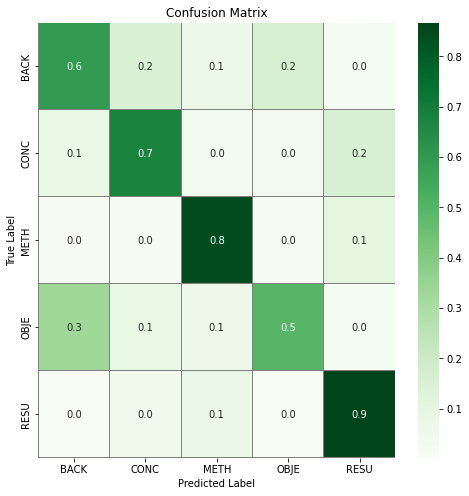

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

word_labels = np.unique(train_df["target"])
word_labels_short = [word_labels[i][:4] for i in np.arange(len(word_labels))]

Y_pred_classes = np.argmax(predictions,axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes, normalize='true') 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
ax.yaxis.set_ticklabels(word_labels_short)
ax.xaxis.set_ticklabels(word_labels_short)
plt.show()

In [51]:
model.save('./drive/MyDrive/assets')

INFO:tensorflow:Assets written to: ./drive/MyDrive/assets/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/assets/assets


In [52]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 128)         8729600   
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 200, 128)         140832    
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 128)               0   